## Modulation classification
train a convolutional neural network for modulation classification. The inpuf of the network is IQ sample (digital) of a signal after effects of raician multipath channel, clock offset and doppler shift.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math
import re
import pandas as pd
import os
import gc




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/gdrive')



ModuleNotFoundError: No module named 'pandas'

In [ ]:
!nvidia-smi

Thu Jul 29 09:42:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load & split data:
Load the data from one of two txt file as csv file.

if  **more_data = False**: load frame.txt that contaion 1100 frames of different modulations (11).

if **more_data = True**: load frame.txt that contaion 11000 frames of different modulations (11).

Then, split the data to train, validation and test.

In [ ]:
# Load Simulation Data
generate_data   = True   # if 0 the script will load the .txt file that generate in 
                          # matlab.
                          # if 1 the script will load numpay matrix of previously 
                          # split data.
more_data       = True   # if 0 load 11 modulation with 100 frame sample each
                          # if 1 load 11 modulation with 10,000 frame sample each
save_database   = True 
path_main = "/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/data/"

if generate_data:
  # Open data files from drive:
  if more_data:
    base_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/frame20_SNR_0_30.txt'
  else:
    base_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/frame.txt'

  # Load data from drive
  data_z = pd.read_csv(base_path,sep=',',header=None)
  data_z = data_z.to_numpy()
  print('Database:')
  print(data_z)
  print('Database shape:    {}'.format(data_z.shape))

  # split data into test valid & train (equally modulation)
  if more_data:
    # ind_train = [i+k for i in range(0,9800) for k in range(0,110000,10000)]
    # ind_valid = [i+k for i in range(9800,9900) for k in range(0,110000,10000)]
    # ind_test = [i+k for i in range(9900,10000) for k in range(0,110000,10000)]
    ind_train = [i+k for i in range(0,9800) for k in range(0,220000,20000)]
    ind_valid = [i+k for i in range(9800,9900) for k in range(0,220000,20000)]
    ind_test = [i+k for i in range(9900,10000) for k in range(0,220000,20000)]
    train = data_z[ind_train]
    valid = data_z[ind_valid]
    test = data_z[ind_test]
  else:
    ind_train = [i+k for i in range(0,80) for k in range(0,1100,100)]
    ind_valid = [i+k for i in range(80,90) for k in range(0,1100,100)]
    ind_test = [i+k for i in range(90,100) for k in range(0,1100,100)]
    train = data_z[ind_train]
    valid = data_z[ind_valid]
    test = data_z[ind_test]

  if save_database:
    # Save data as numpay matrix
    np.save(path_main + '/train.npy', train)
    np.save(path_main + '/valid.npy', valid)
    np.save(path_main + '/test.npy', test)

else:
  train = np.load(path_main + '/train.npy')
  valid = np.load(path_main + '/valid.npy')
  test = np.load(path_main + '/test.npy')


print('Train Length:      {}'.format(len(train)))
print('Validation Length: {}'.format(len(valid)))
print('Test Length:       {}'.format(len(test)))          

Database:
[[ 1.         -0.88697021 -0.63948527 ... -0.30761526 -1.0025048
  -0.37483791]
 [ 1.          0.33149165 -0.11383707 ... -1.22448253  0.06834686
  -1.18686445]
 [ 1.          0.72587414  0.31645139 ...  0.79537989  0.66453688
   0.56816782]
 ...
 [11.          0.08938526 -0.94378515 ...  0.14200769  1.41498737
   1.60642439]
 [11.          1.31926149 -0.30662101 ... -0.45702117  0.29531527
  -0.39637336]
 [11.         -0.01151897  0.06695833 ...  0.7104371  -0.23467492
   0.08896651]]
Database shape:    (220000, 2049)
Train Length:      107800
Validation Length: 1100
Test Length:       1100


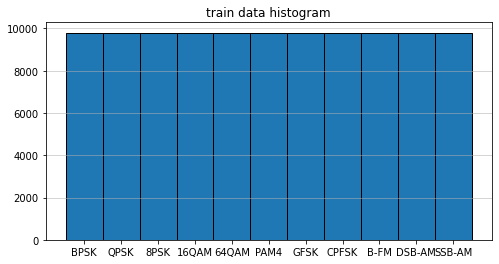

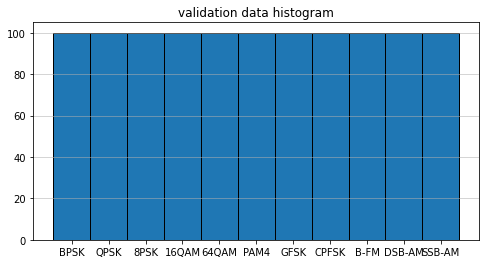

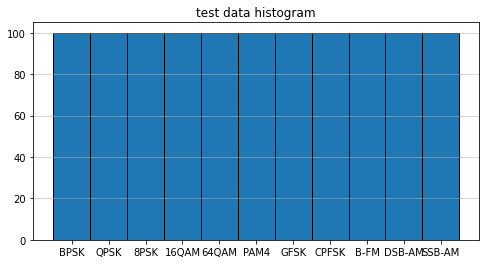

In [ ]:
def plot_data_hist(data, name):
  fig, ax = plt.subplots()
  fig.set_size_inches(8,4)
  #x = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
  ax.hist(data,bins = np.array([1,2,3,4,5,6,7,8,9,10,11,12]), align='left', edgecolor='black')
  modulationTypes = ["BPSK", "QPSK", "8PSK",
    "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK",
    "B-FM", "DSB-AM", "SSB-AM"];
  xticks = [i for i in range(1,12)]
  ax.set_xticks(xticks)
  ax.set_xticklabels(modulationTypes)
  plt.rc('xtick', labelsize=10)
  plt.grid(axis='y', alpha = 0.65)
  plt.title(name)


plot_data_hist(data = train[:,0], name = 'train data histogram')
plot_data_hist(data = valid[:,0], name = 'validation data histogram')
plot_data_hist(data = test[:,0], name = 'test data histogram')

# Batch calculation

Shape_input = True: shapes the input to the correct dimention [num_of_frames,frame_length,sample_dimantion ]:
* num_of_frames - number of frame in mini batch
* frame_length - currently set to 1024. number of samples per frame (from MATLAB)
* sample_dimantion - always 2 for real and imagnery numbers  

Shape_input = False: for one dimentional input [1,2048]

Convert from numpy to tensor

In [ ]:
def get_batch(data, range_min, range_max, shape_input = False, onehot = True):
    """
     return the training data (xt, st) where:
     - `xt` is an numpy array of complex numbers - size 1024x1 ### CHANGE
     - `st` is an numpy scalar value between 1 to 11 
     
     shape_input: make the xt in shape that condiser real and complex values in
     different dimention, then xt shape become [range_max - range_min , 2 , 1024]
     the 2 stand for real/comlex and the 1024 stand of the samples

     onehot: make the label st from scalar to a vector in onehot representaion

    Preconditions:
     - range_max > range_min
    """
    st = data[range_min:range_max,0]
    if onehot:
      st_onehot = np.zeros((batch_size,11))
      if batch_size == 1:
        st_onehot[0,int(st-1)] = 1
      else:
        for i in range(0,batch_size):
          st_onehot[i,int(st[i]-1)] = 1

    xt = data[range_min:range_max,1:]
    if shape_input:
      frame_length = 1024
      num_of_frames = range_max - range_min
      sample_dimantion = 2
      xt = xt.reshape(num_of_frames,frame_length,1,sample_dimantion)  
    
    xt = torch.from_numpy(xt)

    if onehot:
      st_onehot = torch.from_numpy(st_onehot)
      return xt, st_onehot
    else: 
      st = torch.from_numpy(st - 1)
      return xt, st

range_min = 0
range_max = 1
batch_size = range_max - range_min
xt, st = get_batch(test, range_min, range_max,shape_input = True)
print(st)
print((xt))
print(xt.shape)


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[[[-1.0865,  0.4874]],

         [[-0.9685,  0.3701]],

         [[-0.6254, -0.2297]],

         ...,

         [[-0.0840, -0.7739]],

         [[ 0.1371, -0.9201]],

         [[ 0.4896, -0.8409]]]], dtype=torch.float64)
torch.Size([1, 1024, 1, 2])


# Train function





In [ ]:
def get_accurecy(Input, Label, criterion,model):
  # Calaulate the accurecy and the loss givan criterion rule
  Input = Input.cpu()
  Input = Input.float()
  Label = Label.long()
  Input = torch.Tensor(Input).transpose(1, 3)
  Input = Input.to(device)
  Label = Label.to(device)
  model.to(device)
  score, predicted = torch.max(model(Input), 1)
  acc = (Label == predicted).sum().float() / len(Label)
  loss = criterion(model(Input), Label)
  return acc, loss, predicted


def train_model(TrainData, ValidData, model, minibatch_size , epoch , learning_rate, wd, save_model = False):
    model.to(device)
    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.CrossEntropyLoss()

    # we use the optim package to apply
    # SGD for our parameter updates
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # built-in L2
    # Adam for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd) # built-in L2

    train_acc, valid_acc, train_loss, valid_loss = [], [], [], []
    epochs = []
    
    # Training
    for t in range(epoch): 
        # Divide data into mini batches
        
        p = np.random.permutation(len(TrainData))
        TrainData = TrainData[p]
        p = np.random.permutation(len(ValidData))
        ValidData = ValidData[p]
        
        for i in range(0, TrainData.shape[0], minibatch_size):
          # Feed forward to get the logits
          TrainInput ,TrainLabel = get_batch(TrainData, i, i+minibatch_size, shape_input = True, onehot = False)
          ValidInput ,ValidLabel = get_batch(ValidData, 0, minibatch_size, shape_input = True, onehot = False)

          x = TrainInput.float()
          label = TrainLabel.long()
          ValidInput = ValidInput.float()
          ValidLabel = ValidLabel.long()
          x = torch.Tensor(x).transpose(1, 3)
          #print(i)
          #print(x.shape)
          x = x.to(device)
          y_pred = model(x)
          
          # Compute the training loss and accuracy
          loss = criterion(y_pred, label.cuda())
          # zero the gradients before running
          # the backward pass.
          optimizer.zero_grad()
          
          # Backward pass to compute the gradient
          # of loss w.r.t our learnable params. 
          loss.backward()
          
          # Update params
          optimizer.step()

        gc.collect()
        # Compute training accuracy
        acc, _, _ = get_accurecy(TrainInput.cpu(), TrainLabel.cpu(),criterion, model.cpu())

        # Compute the validation accuracy
        Validacc,Validloss, _ = get_accurecy(ValidInput, ValidLabel,criterion, model.cpu())

        
        # Save model
        if save_model:
          name = 'CNN'
          checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/models/' + str(name) + '/epoch-{}.pt'
          torch.save(model.state_dict(), checkpoint_path.format(t))
          
        print("[Epoch]: %i, [Train Loss]: %.6f, [Train ACCURACY]: %.1f %% | [Valid Loss] %.6f [Valid ACCURACY]: %.1f %%" 
              % (t+1, loss.item(), acc*100, Validloss, Validacc*100))
        #display.clear_output(wait=True)
        # clear garbage
        gc.collect()

        # Save error on each epoch
        epochs.append(t) 
        train_acc.append(acc*100)
        valid_acc.append(Validacc*100)
        train_loss.append(loss.item())
        valid_loss.append(Validloss)

        
    # plotting
    # Accurecy
    plt.figure()
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy [%]")
    plt.legend(loc='best')
    plt.grid
    plt.show()     

    # Loss
    plt.figure()
    plt.title("Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, valid_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid
    plt.show()   

# Neural Network Model:

First, implement fully connected network including four layers

In [ ]:
class PyTorchLM(nn.Module):
    def __init__(self, num_hidden=1000):
        super(PyTorchLM, self).__init__()
        self.layer1 = nn.Linear(2048, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, num_hidden)
        self.layer4 = nn.Linear(num_hidden,11)
        self.num_hidden = num_hidden
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, inp):
        inp = inp.reshape([-1, 2048])
        # Layer 1
        inp = self.layer1(inp)
        inp = F.relu(inp)
        inp = self.dropout(inp)
        # Layer 2
        inp = self.layer2(inp)
        inp = F.relu(inp)
        inp = self.dropout(inp)
        # Layer 3
        inp = self.layer3(inp)
        inp = F.relu(inp)
        inp = self.dropout(inp)
        # Layer 4
        inp = self.layer4(inp)
        inp = F.relu(inp)
        return inp
        # Note that we will be using the nn.CrossEntropyLoss(), which computes the softmax operation internally, as loss criterion

In [ ]:
from torchsummary import summary
model = PyTorchLM().to(device)
summary(model, input_size=(2,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]       2,049,000
           Dropout-2                 [-1, 1000]               0
            Linear-3                 [-1, 1000]       1,001,000
           Dropout-4                 [-1, 1000]               0
            Linear-5                 [-1, 1000]       1,001,000
           Dropout-6                 [-1, 1000]               0
            Linear-7                   [-1, 11]          11,011
Total params: 4,062,011
Trainable params: 4,062,011
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 15.50
Estimated Total Size (MB): 15.55
----------------------------------------------------------------


Secound, implementing Convolutional neural network including six convulotional layers and two fully connected layers

In [ ]:
class CNN(nn.Module):
    def __init__(self, n = 4, krn = 3, pad = 3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = n, kernel_size = krn, padding = pad)
        self.conv2 = nn.Conv2d(in_channels = n, out_channels = 2*n, kernel_size = krn, padding = pad)
        self.conv3 = nn.Conv2d(in_channels = 2*n, out_channels = 4*n, kernel_size = krn, padding = pad)
        self.conv4 = nn.Conv2d(in_channels = 4*n, out_channels = 8*n, kernel_size = krn, padding = pad)
        self.conv5 = nn.Conv2d(in_channels = 8*n, out_channels = 16*n, kernel_size = krn, padding = pad)
        self.conv6 = nn.Conv2d(in_channels = 16*n, out_channels = 32*n, kernel_size = krn, padding = pad)
        self.bnorm1 = nn.BatchNorm2d(n)
        self.bnorm2 = nn.BatchNorm2d(2*n)
        self.bnorm3 = nn.BatchNorm2d(4*n)
        self.bnorm4 = nn.BatchNorm2d(8*n)
        self.bnorm5 = nn.BatchNorm2d(16*n)
        self.bnorm6 = nn.BatchNorm2d(32*n)
        self.fc1 = nn.Linear(32*n*(int(1024/(2**6) + pad)*3),100)
        self.bnorm_fc = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 11)
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x, verbose=False):
        # Layer 1 : conv
        #print('in l1: {}'.format(x.shape))
        x = self.conv1(x)
        #x = self.bnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)
        
        #print('in l2: {}'.format(x.shape))
        # Layer 2 : conv
        x = self.conv2(x)
        #x = self.bnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)

        #print('in l3: {}'.format(x.shape))
        # Layer 3 : conv
        x = self.conv3(x)
        #x = self.bnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)

        # Layer 4 : conv
        x = self.conv4(x)
        #x = self.bnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))

        # Layer 5 : conv
        x = self.conv5(x)
        #x = self.bnorm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))

        # Layer 6 : conv
        x = self.conv6(x)
        x = self.bnorm6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))
        
        x = x.view(-1, x.shape[1]*(int(1024/(2**6) + 3)*3) )
        #Layer 5 : Linear
        x = self.fc1(x)
        x = self.bnorm_fc(x)
        x = F.relu(x)
        #x = self.dropout(x)

        # Layer 5 : Linear
        x = self.fc2(x)

        return x

In [ ]:
i = 0
minibatch_size = 5
TrainInput ,TrainLabel = get_batch(train, i, i+minibatch_size, shape_input = True, onehot = False)
ValidInput ,ValidLabel = get_batch(valid, 0, minibatch_size, shape_input = True, onehot = False)

x = TrainInput.float()
#print(x.shape)
label = TrainLabel.long()
ValidInput = ValidInput.float()
ValidLabel = ValidLabel.long()


#print(x.shape)
xs = torch.Tensor(x).transpose(1, 3)
print(xs.shape)
model = CNN(n = 4, krn = 3, pad = 3)
y_pred = model(xs)
print(y_pred.shape)


torch.Size([5, 2, 1, 1024])
torch.Size([5, 11])


In [ ]:
from torchsummary import summary
#model = CNN(n = 4, krn = 3)
model = CNN(n = 4, krn = 3, pad = 3).to(device)
summary(model, input_size=(2,1,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 5, 1028]              76
            Conv2d-2            [-1, 8, 6, 518]             296
            Conv2d-3           [-1, 16, 7, 263]           1,168
            Conv2d-4           [-1, 32, 7, 135]           4,640
            Conv2d-5            [-1, 64, 7, 71]          18,496
            Conv2d-6           [-1, 128, 7, 39]          73,856
       BatchNorm2d-7           [-1, 128, 7, 39]             256
            Linear-8                  [-1, 100]         729,700
       BatchNorm1d-9                  [-1, 100]             200
           Linear-10                   [-1, 11]           1,111
Total params: 829,799
Trainable params: 829,799
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.58
Params size (MB): 3.17
Estimated T

In [ ]:
class CNN_V2(nn.Module):
    def __init__(self, n = 4, krn = 3, pad = 1):
        super(CNN_V2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = n, kernel_size = krn, padding = pad)
        self.conv2 = nn.Conv2d(in_channels = n, out_channels = 2*n, kernel_size = krn, padding = pad)
        self.conv3 = nn.Conv2d(in_channels = 2*n, out_channels = 4*n, kernel_size = krn, padding = pad)
        self.conv4 = nn.Conv2d(in_channels = 4*n, out_channels = 8*n, kernel_size = krn, padding = pad)
        self.conv5 = nn.Conv2d(in_channels = 8*n, out_channels = 16*n, kernel_size = krn, padding = pad)
        self.conv6 = nn.Conv2d(in_channels = 16*n, out_channels = 32*n, kernel_size = krn, padding = pad)
        self.bnorm1 = nn.BatchNorm2d(n)
        self.bnorm2 = nn.BatchNorm2d(2*n)
        self.bnorm3 = nn.BatchNorm2d(4*n)
        self.bnorm4 = nn.BatchNorm2d(8*n)
        self.bnorm5 = nn.BatchNorm2d(16*n)
        self.bnorm6 = nn.BatchNorm2d(32*n)
        self.fc1 = nn.Linear(32*n*(int(1024/(2**6) )),100)
        self.bnorm_fc = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 11)
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x, verbose=False):
        # Layer 1 : conv
        #print('in l1: {}'.format(x.shape))
        x = self.conv1(x)
        #x = self.bnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)

        #print('in l2: {}'.format(x.shape))
        # Layer 2 : conv
        x = self.conv2(x)
        #x = self.bnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)

        #print('in l3: {}'.format(x.shape))
        # Layer 3 : conv
        x = self.conv3(x)
        #x = self.bnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)

        # Layer 4 : conv
        x = self.conv4(x)
        #x = self.bnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))

        # Layer 5 : conv
        x = self.conv5(x)
        #x = self.bnorm5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))

        # Layer 6 : conv
        x = self.conv6(x)
        x = self.bnorm6(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, kernel_size=(1,2))
        #x = self.dropout(x)
        #print('out l4: {}'.format(x.shape))
        
        x = x.view(-1, x.shape[1]*(int(1024/(2**6) ) ))
        #Layer 7 : Linear
        x = self.fc1(x)
        x = self.bnorm_fc(x)
        x = F.relu(x)
        #x = self.dropout(x)

        # Layer 8 : Linear
        x = self.fc2(x)

        return x
  

i = 0
minibatch_size = 100
TrainInput ,TrainLabel = get_batch(train, i, i+minibatch_size, shape_input = True, onehot = False)
ValidInput ,ValidLabel = get_batch(valid, 0, minibatch_size, shape_input = True, onehot = False)

x = TrainInput.float()
#print(x.shape)
label = TrainLabel.long()
ValidInput = ValidInput.float()
ValidLabel = ValidLabel.long()


#print(x.shape)
xs = torch.Tensor(x).transpose(1, 3)
print(xs.shape)
model = CNN_V2(n = 4, krn = 3, pad = 1).to(device)
y_pred = model(xs.to(device))
print(y_pred.shape)

torch.Size([100, 2, 1, 1024])
torch.Size([100, 11])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from torchsummary import summary
model = CNN_V2(n = 10, krn = 3, pad = 1).to(device)
summary(model, input_size=(2,1,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 10, 1, 1024]             190
            Conv2d-2           [-1, 20, 1, 512]           1,820
            Conv2d-3           [-1, 40, 1, 256]           7,240
            Conv2d-4           [-1, 80, 1, 128]          28,880
            Conv2d-5           [-1, 160, 1, 64]         115,360
            Conv2d-6           [-1, 320, 1, 32]         461,120
       BatchNorm2d-7           [-1, 320, 1, 32]             640
            Linear-8                  [-1, 100]         512,100
       BatchNorm1d-9                  [-1, 100]             200
           Linear-10                   [-1, 11]           1,111
Total params: 1,128,661
Trainable params: 1,128,661
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.31
Estimat

# Train process:

[EPOCH]: 0, [LOSS]: 2.399901, [TRAIN ACCURACY]: 7.0 %, [VALID ACCURACY]: 8.0 %
[EPOCH]: 1, [LOSS]: 2.394288, [TRAIN ACCURACY]: 13.0 %, [VALID ACCURACY]: 14.0 %
[EPOCH]: 2, [LOSS]: 2.396072, [TRAIN ACCURACY]: 12.0 %, [VALID ACCURACY]: 14.0 %
[EPOCH]: 3, [LOSS]: 2.396430, [TRAIN ACCURACY]: 16.0 %, [VALID ACCURACY]: 7.0 %
[EPOCH]: 4, [LOSS]: 2.390296, [TRAIN ACCURACY]: 15.0 %, [VALID ACCURACY]: 10.0 %
[EPOCH]: 5, [LOSS]: 2.388163, [TRAIN ACCURACY]: 19.0 %, [VALID ACCURACY]: 9.0 %
[EPOCH]: 6, [LOSS]: 2.389227, [TRAIN ACCURACY]: 17.0 %, [VALID ACCURACY]: 10.0 %
[EPOCH]: 7, [LOSS]: 2.387110, [TRAIN ACCURACY]: 24.0 %, [VALID ACCURACY]: 12.0 %
[EPOCH]: 8, [LOSS]: 2.386246, [TRAIN ACCURACY]: 27.0 %, [VALID ACCURACY]: 9.0 %
[EPOCH]: 9, [LOSS]: 2.382521, [TRAIN ACCURACY]: 19.0 %, [VALID ACCURACY]: 7.0 %
[EPOCH]: 10, [LOSS]: 2.375762, [TRAIN ACCURACY]: 28.0 %, [VALID ACCURACY]: 5.0 %
[EPOCH]: 11, [LOSS]: 2.377887, [TRAIN ACCURACY]: 25.0 %, [VALID ACCURACY]: 11.0 %


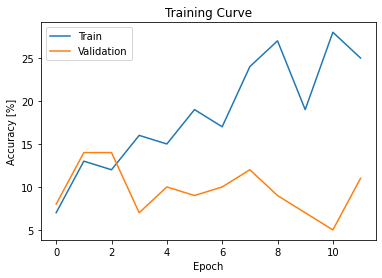

In [ ]:
# Linear model
model = PyTorchLM()
train_model( train, valid, model ,
             minibatch_size = 100,
             epoch = 12 ,
             learning_rate = 1e-5,
             wd = 0)

[Epoch]: 1, [Train Loss]: 1.272693, [Train ACCURACY]: 56.0 % | [Valid Loss] 1.339871 [Valid ACCURACY]: 55.0 %
[Epoch]: 2, [Train Loss]: 1.056305, [Train ACCURACY]: 67.0 % | [Valid Loss] 1.126885 [Valid ACCURACY]: 55.0 %
[Epoch]: 3, [Train Loss]: 0.812311, [Train ACCURACY]: 78.0 % | [Valid Loss] 0.891002 [Valid ACCURACY]: 70.0 %
[Epoch]: 4, [Train Loss]: 0.860426, [Train ACCURACY]: 70.0 % | [Valid Loss] 0.741697 [Valid ACCURACY]: 75.0 %
[Epoch]: 5, [Train Loss]: 0.622187, [Train ACCURACY]: 81.0 % | [Valid Loss] 0.567261 [Valid ACCURACY]: 81.0 %
[Epoch]: 6, [Train Loss]: 0.641066, [Train ACCURACY]: 74.0 % | [Valid Loss] 0.617028 [Valid ACCURACY]: 75.0 %
[Epoch]: 7, [Train Loss]: 0.447271, [Train ACCURACY]: 83.0 % | [Valid Loss] 0.631611 [Valid ACCURACY]: 71.0 %
[Epoch]: 8, [Train Loss]: 0.462859, [Train ACCURACY]: 79.0 % | [Valid Loss] 0.497281 [Valid ACCURACY]: 81.0 %
[Epoch]: 9, [Train Loss]: 0.401931, [Train ACCURACY]: 84.0 % | [Valid Loss] 0.400571 [Valid ACCURACY]: 82.0 %
[Epoch]: 1

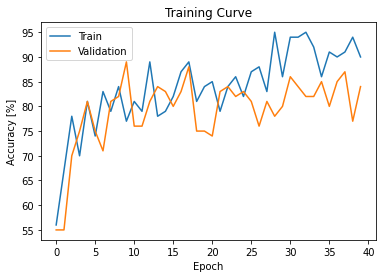

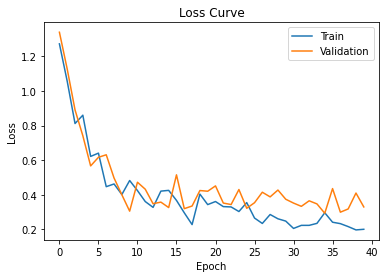

In [ ]:
# CNN_V2 model Version 4
model = CNN_V2(n = 10, krn = 3, pad = 1)
train_model( train, valid, model ,
             minibatch_size = 100,
             epoch = 40 ,
             learning_rate = 1e-5,
             wd = 0,
             save_model = True)

In [ ]:
    import gc
    gc.collect()

    torch.cuda.empty_cache()

[Epoch]: 1, [Train Loss]: 1.205082, [Train ACCURACY]: 62.0 % | [Valid Loss] 1.214751 [Valid ACCURACY]: 64.0 %
[Epoch]: 2, [Train Loss]: 0.889715, [Train ACCURACY]: 70.0 % | [Valid Loss] 0.770927 [Valid ACCURACY]: 81.0 %
[Epoch]: 3, [Train Loss]: 0.658274, [Train ACCURACY]: 81.0 % | [Valid Loss] 0.707475 [Valid ACCURACY]: 79.0 %
[Epoch]: 4, [Train Loss]: 0.536876, [Train ACCURACY]: 82.0 % | [Valid Loss] 0.598590 [Valid ACCURACY]: 74.0 %
[Epoch]: 5, [Train Loss]: 0.588352, [Train ACCURACY]: 75.0 % | [Valid Loss] 0.523777 [Valid ACCURACY]: 78.0 %
[Epoch]: 6, [Train Loss]: 0.489255, [Train ACCURACY]: 79.0 % | [Valid Loss] 0.523385 [Valid ACCURACY]: 82.0 %
[Epoch]: 7, [Train Loss]: 0.534161, [Train ACCURACY]: 75.0 % | [Valid Loss] 0.493923 [Valid ACCURACY]: 79.0 %
[Epoch]: 8, [Train Loss]: 0.444648, [Train ACCURACY]: 82.0 % | [Valid Loss] 0.432402 [Valid ACCURACY]: 81.0 %
[Epoch]: 9, [Train Loss]: 0.353762, [Train ACCURACY]: 83.0 % | [Valid Loss] 0.429666 [Valid ACCURACY]: 79.0 %
[Epoch]: 1

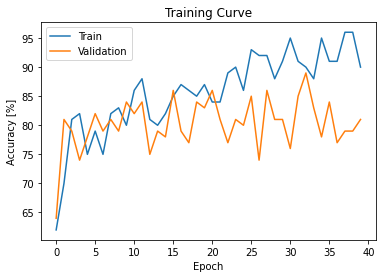

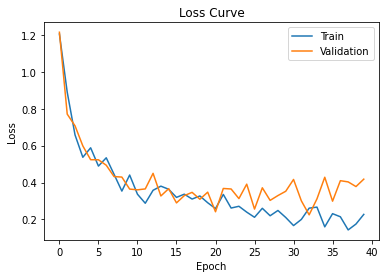

In [ ]:
# CNN_V2 model Version 5
model = CNN_V2(n = 10, krn = (3,5), pad = (1,2))
train_model( train, valid, model ,
             minibatch_size = 100,
             epoch = 40 ,
             learning_rate = 1e-5,
             wd = 0,
             save_model = True)

[Epoch]: 1, [Train Loss]: 1.406326, [Train ACCURACY]: 48.0 % | [Valid Loss] 1.254783 [Valid ACCURACY]: 48.0 %
[Epoch]: 2, [Train Loss]: 1.285189, [Train ACCURACY]: 49.0 % | [Valid Loss] 1.054197 [Valid ACCURACY]: 58.0 %
[Epoch]: 3, [Train Loss]: 1.107868, [Train ACCURACY]: 56.0 % | [Valid Loss] 1.044525 [Valid ACCURACY]: 58.0 %
[Epoch]: 4, [Train Loss]: 1.083390, [Train ACCURACY]: 58.0 % | [Valid Loss] 1.166427 [Valid ACCURACY]: 55.0 %
[Epoch]: 5, [Train Loss]: 1.163435, [Train ACCURACY]: 50.0 % | [Valid Loss] 1.113345 [Valid ACCURACY]: 51.0 %
[Epoch]: 6, [Train Loss]: 1.012397, [Train ACCURACY]: 58.0 % | [Valid Loss] 1.042907 [Valid ACCURACY]: 54.0 %
[Epoch]: 7, [Train Loss]: 1.137268, [Train ACCURACY]: 53.0 % | [Valid Loss] 1.143896 [Valid ACCURACY]: 46.0 %
[Epoch]: 8, [Train Loss]: 1.127318, [Train ACCURACY]: 52.0 % | [Valid Loss] 0.998463 [Valid ACCURACY]: 59.0 %
[Epoch]: 9, [Train Loss]: 0.959717, [Train ACCURACY]: 61.0 % | [Valid Loss] 1.172434 [Valid ACCURACY]: 45.0 %
[Epoch]: 1

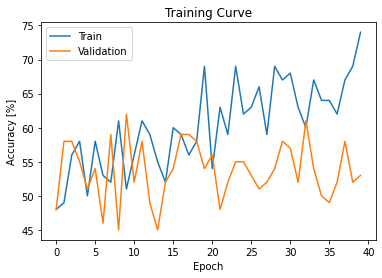

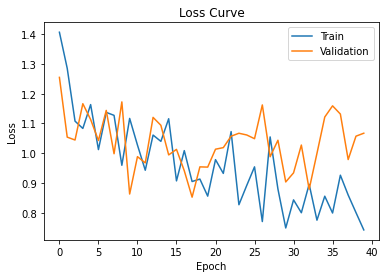

In [ ]:
# CNN_V2 model fft base
model = CNN_V2(n = 10, krn = 3, pad = 1)
train_model( train, valid, model ,
             minibatch_size = 100,
             epoch = 40 ,
             learning_rate = 1e-5,
             wd = 0,
             save_model = True)

[Epoch]: 1, [Train Loss]: 0.962875, [Train ACCURACY]: 72.0 % | [Valid Loss] 1.019143 [Valid ACCURACY]: 72.0 %
[Epoch]: 2, [Train Loss]: 0.772141, [Train ACCURACY]: 76.0 % | [Valid Loss] 0.807585 [Valid ACCURACY]: 67.0 %
[Epoch]: 3, [Train Loss]: 0.667011, [Train ACCURACY]: 69.0 % | [Valid Loss] 0.676760 [Valid ACCURACY]: 73.0 %
[Epoch]: 4, [Train Loss]: 0.515833, [Train ACCURACY]: 82.0 % | [Valid Loss] 0.509745 [Valid ACCURACY]: 79.0 %
[Epoch]: 5, [Train Loss]: 0.490836, [Train ACCURACY]: 81.0 % | [Valid Loss] 0.529553 [Valid ACCURACY]: 79.0 %
[Epoch]: 6, [Train Loss]: 0.476747, [Train ACCURACY]: 82.0 % | [Valid Loss] 0.490943 [Valid ACCURACY]: 74.0 %
[Epoch]: 7, [Train Loss]: 0.418411, [Train ACCURACY]: 79.0 % | [Valid Loss] 0.327694 [Valid ACCURACY]: 86.0 %
[Epoch]: 8, [Train Loss]: 0.315423, [Train ACCURACY]: 87.0 % | [Valid Loss] 0.433419 [Valid ACCURACY]: 83.0 %
[Epoch]: 9, [Train Loss]: 0.372673, [Train ACCURACY]: 82.0 % | [Valid Loss] 0.435178 [Valid ACCURACY]: 82.0 %
[Epoch]: 1

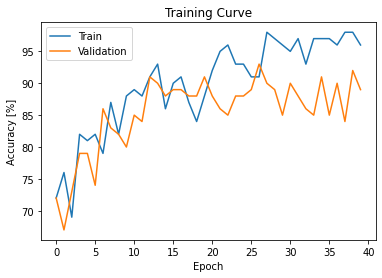

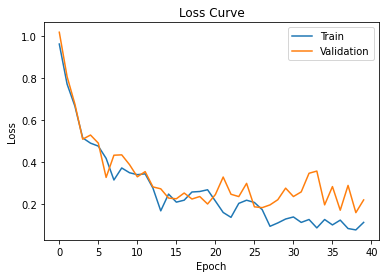

In [ ]:
# All SNR 0-30
model = CNN_V2(n = 10, krn = 3, pad = 1)
train_model( train, valid, model ,
             minibatch_size = 100,
             epoch = 40 ,
             learning_rate = 1e-5,
             wd = 0,
             save_model = True)

# Test

In [ ]:
#Load model
nm = 'epoch-39'
model = CNN_V2(n = 10, krn = 3, pad = 1).to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/models/CNN/'+ nm + '.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Print Accurecy and Loss of Test 
TestInput ,TestLabel = get_batch(test, 0, 1100, shape_input = True, onehot = False)
criterion = torch.nn.CrossEntropyLoss()
TestAcc, Testloss,TestPred = get_accurecy(TestInput, TestLabel, criterion,model)

print('Test Accurecy = {}% , Test Loss = {}'.format(TestAcc*100,Testloss))


print(TestAcc)

Test Accurecy = 90.09091186523438% , Test Loss = 0.19891749322414398
tensor(0.9009, device='cuda:0')


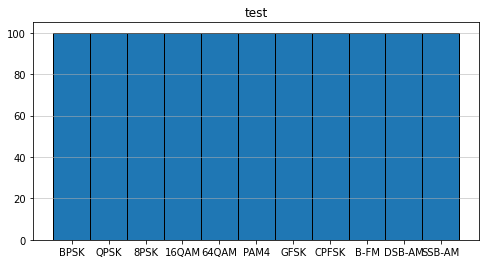

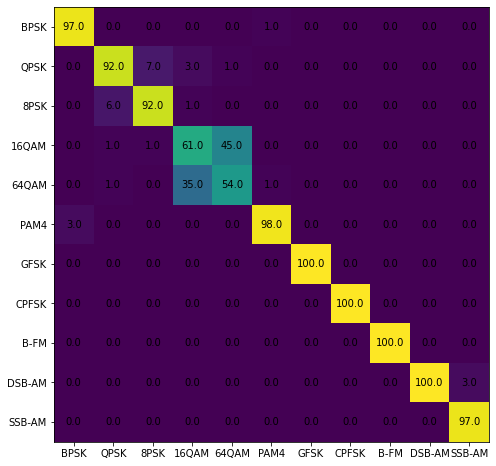

In [ ]:
#initialize
conf_mat = np.zeros([11,11])
odulationTypes = ["BPSK", "QPSK", "8PSK",
    "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK",
    "B-FM", "DSB-AM", "SSB-AM"];
 
plot_data_hist(data = TestLabel+1, name = 'test')
 
# Generate matrix
for i in range(len(TestLabel)):
  conf_mat[int(TestPred[i]),int(TestLabel[i])] += 1
 
# plot matrix
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.imshow(conf_mat)
modulationTypes = ["BPSK", "QPSK", "8PSK",
  "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK",
  "B-FM", "DSB-AM", "SSB-AM"];
ticks = [i for i in range(0,11)]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(modulationTypes)
ax.set_yticklabels(modulationTypes)
plt.rc('xtick', labelsize=10)
# add values
x, y = np.meshgrid(range(11), range(11))
for x_val,y_val in zip(x.flatten(), y.flatten()):
  ax.text(y_val, x_val, conf_mat[x_val,y_val], va='center', ha='center')

# Test for different SNR:
Using the same model on samples with different SNR

(1100, 2049)
Test Accurecy = 79.0% , Test Loss = 0.5104068517684937
tensor(0.7900)


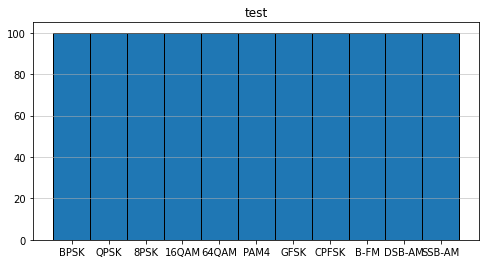

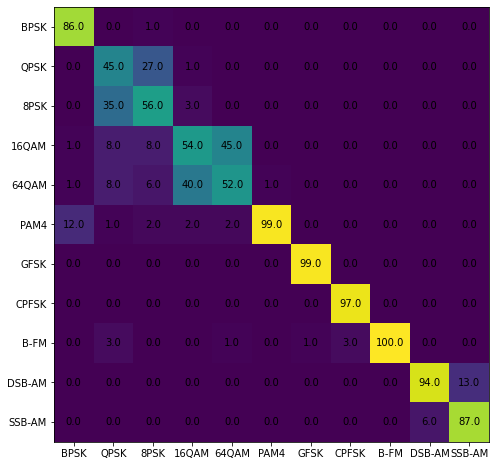

In [ ]:
base_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/ModData/frame_PDP.txt'

# Load data from drive

test = pd.read_csv(base_path,sep=',',header=None)
test = test.to_numpy()

print(test.shape)
#print('Database:')
#print(test)
#print('Database shape:    {}'.format(test.shape))

# Print Accurecy and Loss of Test 
TestInput ,TestLabel = get_batch(test, 0, 1100, shape_input = True, onehot = False)
criterion = torch.nn.CrossEntropyLoss()
TestAcc, Testloss,TestPred = get_accurecy(TestInput, TestLabel, criterion,model)

print('Test Accurecy = {}% , Test Loss = {}'.format(TestAcc*100,Testloss))


print(TestAcc)


#initialize
conf_mat = np.zeros([11,11])
odulationTypes = ["BPSK", "QPSK", "8PSK",
    "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK",
    "B-FM", "DSB-AM", "SSB-AM"];
 
plot_data_hist(data = TestLabel+1, name = 'test')
 
# Generate matrix
for i in range(len(TestLabel)):
  conf_mat[int(TestPred[i]),int(TestLabel[i])] += 1
 
# plot matrix
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.imshow(conf_mat)
modulationTypes = ["BPSK", "QPSK", "8PSK",
  "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK",
  "B-FM", "DSB-AM", "SSB-AM"];
ticks = [i for i in range(0,11)]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(modulationTypes)
ax.set_yticklabels(modulationTypes)
plt.rc('xtick', labelsize=10)
# add values
x, y = np.meshgrid(range(11), range(11))
for x_val,y_val in zip(x.flatten(), y.flatten()):
  ax.text(y_val, x_val, conf_mat[x_val,y_val], va='center', ha='center')